<a href="https://colab.research.google.com/github/ArwaSaif99/movie_recommendation_system/blob/main/recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RATING DISTRIBUTION

In [32]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

ratings = pd.read_csv('/content/ratings.csv', sep=',', on_bad_lines='warn')

user_counter = Counter(ratings['userId'])
movie_counter = Counter(ratings['movieId'])

user_freq = Counter(user_counter.values())
movie_freq = Counter(movie_counter.values())

user_degree = list(user_freq.keys())
ratings_by_user = list(user_freq.values())

movies_degree = list(movie_freq.keys())
ratings_by_movie = list(movie_freq.values())




# log-log scale scatter plot

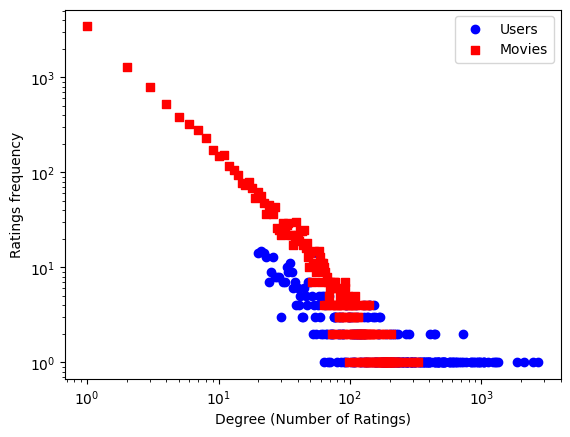

In [33]:

plt.scatter(user_degree, ratings_by_user, marker='o', color='blue', label='Users')
plt.scatter(movies_degree, ratings_by_movie, marker='s', color='red', label='Movies')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree (Number of Ratings)')
plt.ylabel('Ratings frequency')
plt.legend()
plt.savefig('log-log.pdf', format='pdf')

plt.show()

# **Biases Only**

In [34]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

ratings = pd.read_csv('/content/ratings.csv', sep=',', on_bad_lines='warn')



USER AND MOVIE INDEXING

In [35]:
user_to_idx = {}
movie_to_idx = {}
id_to_user = []
id_to_movie = []


for row in ratings.itertuples():
    user_id = row.userId
    movie_id = row.movieId

    if user_id not in user_to_idx:
        user_idx = len(user_to_idx)
        user_to_idx[user_id] = user_idx
        id_to_user.append(user_id)

    if movie_id not in movie_to_idx:
        movie_idx = len(movie_to_idx)
        movie_to_idx[movie_id] = movie_idx
        id_to_movie.append(movie_id)


In [36]:

ratings_by_users = [[] for _ in range(len(user_to_idx))]
ratings_by_movies = [[] for _ in range(len(movie_to_idx))]

for row in ratings.itertuples():
    user = row.userId
    movie = row.movieId
    rating = row.rating

    user_idx = user_to_idx[user]
    movie_idx = movie_to_idx[movie]

    ratings_by_users[user_idx].append((movie_idx, rating))
    ratings_by_movies[movie_idx].append((user_idx, rating))

DATA SPLITTING

In [37]:

def split_ratings(ratings, train_ratio=0.8):
    train_set = []
    test_set = []
    for user_ratings in ratings:
        split_index = int(len(user_ratings) * train_ratio)
        train_set.append(user_ratings[:split_index])
        test_set.append(user_ratings[split_index:])
    return train_set, test_set

ratings_by_users_train, ratings_by_users_test = split_ratings(ratings_by_users)

Biases Initialization

In [38]:
from re import T
lambda_ = 0.01
iterations = 10

movie_biases = np.zeros(len(ratings_by_movies))
user_biases = np.zeros(len(ratings_by_users))

train_loss = []
test_loss = []
train_rmse = []
test_rmse = []


In [39]:

def calculate_loss(train_ratings, biases_user, biases_movie,):
    total_loss = 0
    for user_index, user_ratings in enumerate(train_ratings):
        for movie_index, actual_rating in user_ratings:
            predicted_rating = biases_user[user_index] + biases_movie[movie_index]
            rating_error = actual_rating - predicted_rating
            total_loss += (rating_error) ** 2
    return total_loss

def calculate_rmse(training_ratings, user_biases, movie_biases):
    total_squared_error = 0
    total_count = 0

    for current_user_id, user_ratings in enumerate(training_ratings):
        for current_movie_id, actual_rating in user_ratings:
            predicted_rating = user_biases[current_user_id] + movie_biases[current_movie_id]
            error = actual_rating - predicted_rating
            total_squared_error += error ** 2
            total_count += 1

    rmse = np.sqrt(total_squared_error / total_count) if total_count > 0 else 0
    return rmse

def update_user_biases(ratings, user_biases, movie_biases, lambda_):
    for user_index in range(len(ratings)):
        bias_sum = 0
        count_ratings = 0
        for movie_index, rating in ratings[user_index]:
            bias_sum += rating - movie_biases[movie_index]
            count_ratings += 1
        if count_ratings > 0:
            user_biases[user_index] = bias_sum / (count_ratings + lambda_)

def update_movie_biases(ratings, user_biases, movie_biases, lambda_):
    for movie_index in range(len(ratings)):
        bias_sum = 0
        count_ratings = 0
        for user_index, rating in ratings[movie_index]:
            bias_sum += rating - user_biases[user_index]
            count_ratings += 1
        if count_ratings > 0:
            movie_biases[movie_index] = bias_sum / (count_ratings + lambda_)

In [40]:

for iteration in range(iterations):
    update_user_biases(ratings_by_users_train, user_biases, movie_biases, lambda_)
    update_movie_biases(ratings_by_movies, user_biases, movie_biases, lambda_)

    train_loss_value = calculate_loss(ratings_by_users_train, user_biases, movie_biases, )
    test_loss_value = calculate_loss(ratings_by_users_test, user_biases, movie_biases, )

    train_rmse_value = calculate_rmse(ratings_by_users_train, user_biases, movie_biases)
    test_rmse_value = calculate_rmse(ratings_by_users_test, user_biases, movie_biases)

    train_loss.append(train_loss_value)
    test_loss.append(test_loss_value)
    train_rmse.append(train_rmse_value)
    test_rmse.append(test_rmse_value)

    print(f"Iteration {iteration + 1}: Train Loss = {train_loss_value}, Test Loss = {test_loss_value}, Train RMSE = {train_rmse_value}, Test RMSE = {test_rmse_value}")




Iteration 1: Train Loss = 52586.088689055505, Test Loss = 13060.95122755143, Train RMSE = 0.8086416391403272, Test RMSE = 0.7998184893376379
Iteration 2: Train Loss = 50284.0565873637, Test Loss = 12443.439793881023, Train RMSE = 0.7907438429779405, Test RMSE = 0.7806821707365817
Iteration 3: Train Loss = 50143.70533961966, Test Loss = 12387.876307921071, Train RMSE = 0.7896395224131163, Test RMSE = 0.7789372370571244
Iteration 4: Train Loss = 50133.454599623314, Test Loss = 12377.681534866246, Train RMSE = 0.7895588063680913, Test RMSE = 0.7786166525340835
Iteration 5: Train Loss = 50132.84020189113, Test Loss = 12374.637308276268, Train RMSE = 0.7895539682352495, Test RMSE = 0.7785208982820393
Iteration 6: Train Loss = 50132.96299889249, Test Loss = 12373.524341373177, Train RMSE = 0.7895549352141794, Test RMSE = 0.7784858876609263
Iteration 7: Train Loss = 50133.071580345066, Test Loss = 12373.083007728716, Train RMSE = 0.7895557902501698, Test RMSE = 0.7784720041840714
Iteration 8:

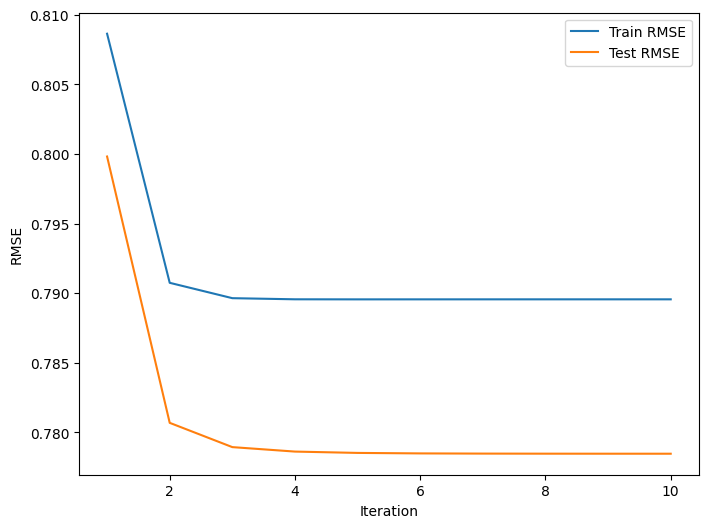

In [41]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_rmse) + 1), train_rmse, label="Train RMSE")
plt.plot(range(1, len(test_rmse) + 1), test_rmse, label="Test RMSE")
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.savefig('RMSE_biases.pdf', format='pdf')

plt.show()

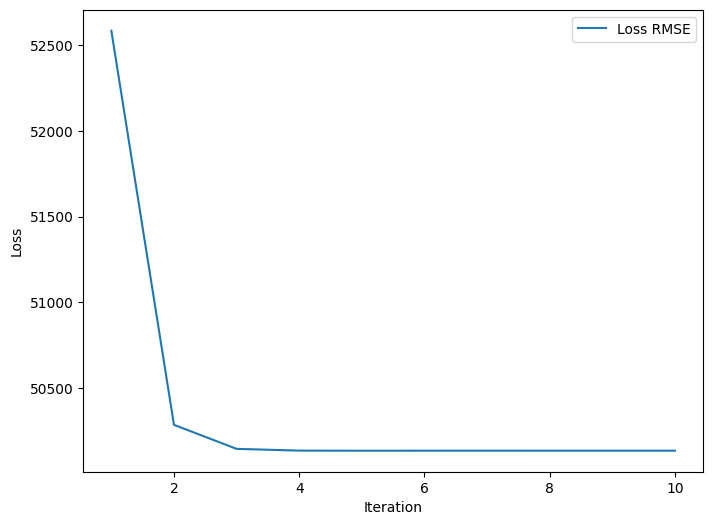

In [42]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label="Loss RMSE")
# plt.plot(range(1, len(test_loss) + 1), test_loss, label="Loss RMSE")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Loss_biases.pdf', format='pdf')

plt.show()

#  **Latent Vectors**

USER AND MOVIE INDEXING

In [43]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

ratings = pd.read_csv('/content/ratings.csv', sep=',', on_bad_lines='warn')

user_to_idx = {}
movie_to_idx = {}
id_to_user = []
id_to_movie = []

for row in ratings.itertuples():
    user_id = row.userId
    movie_id = row.movieId

    if user_id not in user_to_idx:
        user_idx = len(user_to_idx)
        user_to_idx[user_id] = user_idx
        id_to_user.append(user_id)

    if movie_id not in movie_to_idx:
        movie_idx = len(movie_to_idx)
        movie_to_idx[movie_id] = movie_idx
        id_to_movie.append(movie_id)

In [44]:

ratings_by_users = []
for user_index in range(len(user_to_idx)):
    ratings_by_users.append([])

ratings_by_movies = []
for movie_index in range(len(movie_to_idx)):
    ratings_by_movies.append([])


In [45]:

for row in ratings.itertuples():
    user = row.userId
    movie = row.movieId
    rating = row.rating

    user_idx = user_to_idx[user]
    movie_idx = movie_to_idx[movie]

    ratings_by_users[user_idx].append((movie_idx, rating))
    ratings_by_movies[movie_idx].append((user_idx, rating))

In [46]:


ratings_by_users_train = []
for user_index in range(len(ratings_by_users)):
    ratings_by_users_train.append([])

ratings_by_users_test = []
for user_index in range(len(ratings_by_users)):
    ratings_by_users_test.append([])

ratings_by_movies_train = []
for movie_index in range(len(ratings_by_movies)):
    ratings_by_movies_train.append([])

ratings_by_movies_test = []
for movie_index in range(len(ratings_by_movies)):
    ratings_by_movies_test.append([])


DATA SPLITTING

In [47]:
def split_ratings(ratings, train_ratio=0.8):
    train_set = []
    test_set = []
    for user_ratings in ratings:
        split_index = int(len(user_ratings) * train_ratio)
        train_set.append(user_ratings[:split_index])
        test_set.append(user_ratings[split_index:])
    return train_set, test_set

ratings_by_users_train, ratings_by_users_test = split_ratings(ratings_by_users)
ratings_by_movies_train, ratings_by_movies_test = split_ratings(ratings_by_movies)

Biases and Latent Vectors Initialization

In [48]:
lambda_ = 0.5
gamma = 0.5
tau = 5
iterations = 10
k = 10

movie_biases = np.zeros(len(ratings_by_movies_train))
user_biases = np.zeros(len(ratings_by_users_train))

user_vectors = np.random.uniform(0, 1 / np.sqrt(k), (len(ratings_by_users_train), k))
movie_vectors = np.random.uniform(0, 1 / np.sqrt(k), (len(ratings_by_movies_train), k))

train_loss = []
test_loss = []
train_rmse = []
test_rmse = []


Loss Calculation

In [49]:
def calculate_loss(train_ratings, biases_user, biases_movie, vectors_user, vectors_movie,):
    total_loss = 0

    for user_index, user_ratings in enumerate(train_ratings):
        for movie_index, actual_rating in user_ratings:
            predicted_rating = np.dot(vectors_user[user_index], vectors_movie[movie_index]) + biases_user[user_index] + biases_movie[movie_index]
            rating_error = actual_rating - predicted_rating
            total_loss += (rating_error) ** 2

    return total_loss


ROOT MEAN SQUARE ERROR CALCULATION

In [50]:
def calculate_rmse(training_ratings, user_biases, movie_biases, user_vectors, movie_vectors):
    total_squared_error = 0
    total_count = 0

    for current_user_id, user_ratings in enumerate(training_ratings):
        for current_movie_id, actual_rating in user_ratings:
            predicted_rating = np.dot(user_vectors[current_user_id], movie_vectors[current_movie_id]) + user_biases[current_user_id] + movie_biases[current_movie_id]
            error = actual_rating - predicted_rating
            total_squared_error += error ** 2
            total_count += 1

    rmse = np.sqrt(total_squared_error / total_count) if total_count > 0 else 0
    return rmse


In [51]:
def update_user_biases(ratings, user_vectors, movie_vectors, movie_biases, user_biases, lambda_):
    for user_index in range(len(ratings)):
        bias_sum = 0
        count_ratings = 0
        for movie_index, rating in ratings[user_index]:
            bias_sum += rating - movie_biases[movie_index] - np.dot(user_vectors[user_index], movie_vectors[movie_index])
            count_ratings += 1
        if count_ratings > 0:
            user_biases[user_index] = bias_sum / (count_ratings + lambda_)


def update_user_latent_factors(ratings, user_vectors, movie_vectors, movie_biases, user_biases, tau, k, lambda_):
    for user_index in range(len(ratings)):
        rated_movies = [entry for entry in ratings[user_index] if entry[1] != 0]
        if rated_movies:
            movie_indices = [movie for movie, _ in rated_movies]
            V_T_V = np.dot(movie_vectors[movie_indices].T, movie_vectors[movie_indices]) + tau * np.eye(k)
            right_hand_side = np.dot(movie_vectors[movie_indices].T,
                                      [rating - movie_biases[movie] - user_biases[user_index] for movie, rating in rated_movies])
            user_vectors[user_index] = np.linalg.solve(V_T_V + lambda_ * np.eye(k), right_hand_side)


def update_movie_biases(ratings, user_vectors, movie_vectors, user_biases, movie_biases, lambda_):
    for movie_index in range(len(ratings)):
        bias_sum = 0
        count_ratings = 0
        for user_index, rating in ratings[movie_index]:
            bias_sum += rating - user_biases[user_index] - np.dot(user_vectors[user_index], movie_vectors[movie_index])
            count_ratings += 1
        if count_ratings > 0:
            movie_biases[movie_index] = bias_sum / (count_ratings + lambda_)


def update_movie_latent_factors(ratings, user_vectors, movie_vectors, user_biases, movie_biases, tau, k, lambda_):
    for movie_index in range(len(ratings)):
        rated_users = [entry for entry in ratings[movie_index] if entry[1] != 0]
        if rated_users:
            user_indices = [user for user, _ in rated_users]
            U_T_U = np.dot(user_vectors[user_indices].T, user_vectors[user_indices]) + tau * np.eye(k)
            right_hand_side = np.dot(user_vectors[user_indices].T,
                                     [rating - user_biases[user] - movie_biases[movie_index] for user, rating in rated_users])
            movie_vectors[movie_index] = np.linalg.solve(U_T_U + lambda_ * np.eye(k), right_hand_side)



In [52]:
for iteration in range(iterations):
    update_user_biases(ratings_by_users_train, user_vectors, movie_vectors, movie_biases, user_biases, lambda_)
    update_user_latent_factors(ratings_by_users_train, user_vectors, movie_vectors, movie_biases, user_biases, tau, k, lambda_)
    update_movie_biases(ratings_by_movies_train, user_vectors, movie_vectors, user_biases, movie_biases, lambda_)
    update_movie_latent_factors(ratings_by_movies_train, user_vectors, movie_vectors, user_biases, movie_biases, tau, k, lambda_)

    train_loss_value = calculate_loss(ratings_by_users_train, user_biases, movie_biases, user_vectors, movie_vectors, )
    test_loss_value  = calculate_loss(ratings_by_users_test, user_biases, movie_biases, user_vectors, movie_vectors,)

    train_rmse_value  = calculate_rmse(ratings_by_users_train, user_biases, movie_biases, user_vectors, movie_vectors)
    test_rmse_value = calculate_rmse(ratings_by_users_test, user_biases, movie_biases, user_vectors, movie_vectors)

    train_loss.append(train_loss_value )
    test_loss.append(test_loss_value )
    train_rmse.append(train_rmse_value )
    test_rmse.append(test_rmse_value )

    print(f"Iteration {iteration + 1}: Train Loss = {train_loss_value}, Test Loss = {test_loss_value}, Train RMSE = {train_rmse_value}, Test RMSE = {test_rmse_value}")



Iteration 1: Train Loss = 52342.661878383515, Test Loss = 15141.577051964028, Train RMSE = 0.8067678223831265, Test RMSE = 0.861171385817479
Iteration 2: Train Loss = 39579.28761444282, Test Loss = 12188.44796957507, Train RMSE = 0.7015435762861806, Test RMSE = 0.7726418705551363
Iteration 3: Train Loss = 36483.30668957939, Test Loss = 11480.788769088203, Train RMSE = 0.6735467777452485, Test RMSE = 0.7498767680211974
Iteration 4: Train Loss = 35314.53084396187, Test Loss = 11263.69665065299, Train RMSE = 0.6626701165421119, Test RMSE = 0.7427531605213904
Iteration 5: Train Loss = 34716.872897869194, Test Loss = 11171.280069275475, Train RMSE = 0.6570387226683855, Test RMSE = 0.7396998073076423
Iteration 6: Train Loss = 34325.46571137015, Test Loss = 11116.452156169787, Train RMSE = 0.6533244099850801, Test RMSE = 0.7378823754292637
Iteration 7: Train Loss = 34041.36464412074, Test Loss = 11078.746404095999, Train RMSE = 0.6506151121630155, Test RMSE = 0.7366299055660228
Iteration 8: T

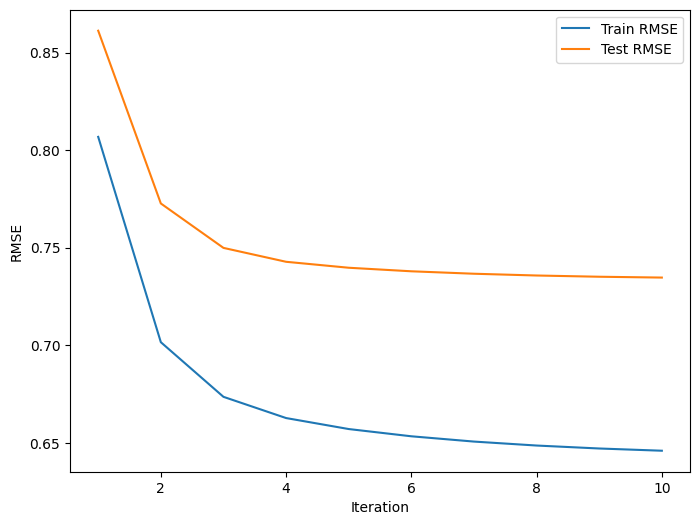

In [53]:

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_rmse) + 1), train_rmse, label="Train RMSE")
plt.plot(range(1, len(test_rmse) + 1), test_rmse, label="Test RMSE")
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.savefig('RMSE_latent.pdf', format='pdf')

plt.show()

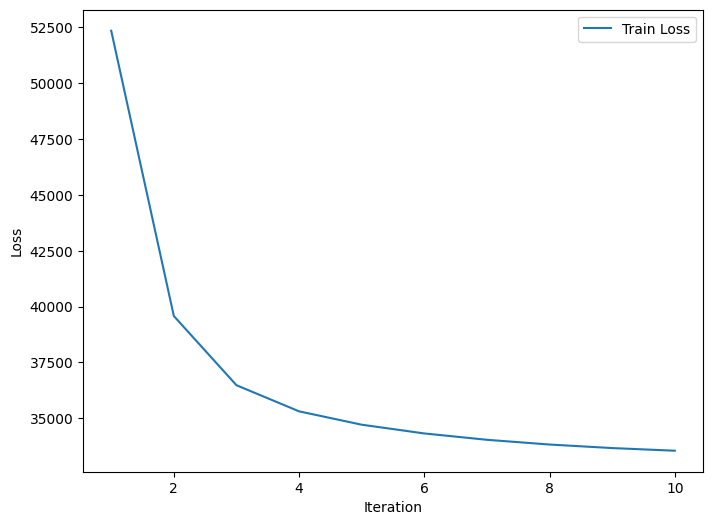

In [54]:

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label="Train Loss")
# plt.plot(range(1, len(test_loss) + 1), test_loss, label="Test Loss")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_latent.pdf', format='pdf')

plt.show()

Dummy User

In [55]:
import pandas as pd
import numpy as np

movie_data = pd.read_csv('/content/movies.csv')

def search_movie_id(query):
    matches = movie_data[movie_data['title'].str.lower().str.contains(query.lower(), regex=False)]
    if not matches.empty:
        return movie_to_idx.get(matches.iloc[0]['movieId'], None)
    return None

def adjust_profile(vector, bias, ratings):
    bias_total = sum(rating - movie_biases[movie] - np.dot(vector, movie_vectors[movie]) for movie, rating in ratings)
    if ratings:
        bias = bias_total / (len(ratings) + lambda_)
    for movie, rating in ratings:
        adjustment = np.dot(movie_vectors[movie].T, movie_vectors[movie]) + tau * np.eye(k)
        target = movie_vectors[movie] * (rating - movie_biases[movie] - bias)
        vector = np.linalg.solve(adjustment + lambda_ * np.eye(k), target)
    return vector, bias

def recommend_movies(vector, bias, exclude_idx=None, top_n=10):
    scored_movies = [(idx, np.dot(vector, movie_vectors[idx]) + 0.05 * movie_biases[idx] + bias)
                     for idx in range(len(movie_vectors)) if idx != exclude_idx]
    top_choices = sorted(scored_movies, key=lambda x: x[1], reverse=True)[:top_n]
    return [(id_to_movie[movie_id], score) for movie_id, score in top_choices]

title_query = "Harry Potter"
movie_idx = search_movie_id(title_query)

if movie_idx is not None:
    profile_vector, profile_bias = np.zeros(k), 0.0
    favorite_ratings = [(movie_idx, 5.0)]
    profile_vector, profile_bias = adjust_profile(profile_vector, profile_bias, favorite_ratings)

    top_movies = recommend_movies(profile_vector, profile_bias, exclude_idx=movie_idx)

    print("Recommended Movies:")
    for movie_id, score in top_movies:
        title = movie_data[movie_data['movieId'] == movie_id]['title'].values[0]
        print(f"{title} - Score: {score:.2f}")
else:
    print("Movie not found.")


Recommended Movies:
Harry Potter and the Order of the Phoenix (2007) - Score: 3.13
Harry Potter and the Chamber of Secrets (2002) - Score: 3.12
Harry Potter and the Prisoner of Azkaban (2004) - Score: 3.12
Harry Potter and the Deathly Hallows: Part 2 (2011) - Score: 3.10
Harry Potter and the Goblet of Fire (2005) - Score: 3.10
Harry Potter and the Deathly Hallows: Part 1 (2010) - Score: 3.09
First Knight (1995) - Score: 3.09
Little Mermaid, The (1989) - Score: 3.09
Dead Poets Society (1989) - Score: 3.09
Harry Potter and the Half-Blood Prince (2009) - Score: 3.08
